# Homework 5: Failure Transition Heat-Map

In this notebook, we will cover:

- How to define online scorers to evaluate agent steps in addition to trace-level scorers to evaluate the final result
- How to capture agent steps in Braintrust
- How to generate some new data using our "golden" user queries dataset
- Fetch logs to create a failure transation dataset
- Build a failure transation heat map


In [ ]:
import json
import os
import sys

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath(".."))
import braintrust as bt
import openai as oai
import requests

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from backend.utils import get_agent_response

load_dotenv(override=True)

True

## Setup


In [3]:
BT_PROJECT_NAME = "recipe-bot"
bt_project = bt.projects.create(name=BT_PROJECT_NAME)

## Step 1: Define on-line scorers


We define [online scorers](https://www.braintrust.dev/docs/guides/projects#online-scoring) in braintrust to evaluate our application in real-time.

In this example, we've created scorers to evaluate the overall result as well as a couple of the intermediate steps our agent can take. For example, we utilize our dietary preferences scorer to evaluate the agent's final response in addition to a possibility scorer to evaluate the relevancy of the retrived recipes during the recipe retrieval step.

See our [evaluating agents document](https://www.braintrust.dev/docs/best-practices/agents#evaluating-agents) for more information on how to [structure your agent evaluations](https://www.braintrust.dev/docs/best-practices/agents#structuring-agent-evaluations).

<img src="./data/online-scorer-example.png" width="800"/>


## Step 2: Update `utils.py` to capture agent steps in Braintrust

We identify each "step" in our agent via metadata associated to the relevant spans. This allows us to easily identify the various steps our agent takes in each trace.


<img src="./data/updated-logs.png" width="800"/>


## Step 3: Run the bot on our curated user queries


In [4]:
all_queries_ds = bt.init_dataset(project=BT_PROJECT_NAME, name="user_queries")
rows = list(all_queries_ds)

print(len(rows))
rows[0]

135


{'_pagination_key': 'p07532347662115799127',
 '_xact_id': '1000195526757082408',
 'created': '2025-07-29T03:55:53.713Z',
 'dataset_id': '15b4cc00-8f27-400b-a312-31cb036fe7e4',
 'expected': None,
 'id': '44de1888-c29f-4288-b213-d6486ed0727e',
 'input': 'can u help me find a quick recipe with salmon and avocado from trader joes? need some nutritional guidance for this dish',
 'is_root': True,
 'metadata': {'id': '20250728_2025_001',
  'model': 'gpt-4o-mini',
  'model_kwargs': {},
  'source': 'synth'},
 'origin': None,
 'project_id': '54782088-3418-41ea-acda-d6302c2dfa64',
 'root_span_id': 'f55838b6-87ac-4d16-ba73-6835b97753e3',
 'span_id': 'f55838b6-87ac-4d16-ba73-6835b97753e3',
 'tags': None}

In [5]:
get_agent_response(
    messages=[{"role": "user", "content": rows[0]["input"]}],  # type: ignore
    metadata=rows[0]["metadata"],  # type: ignore
)

[{'role': 'system',
  'content': '# Role and Objective\nYou are a friendly, health-conscious culinary assistant. Your primary goal is to provide **easy-to-follow, high-protein, macro-friendly, and meal-prep-friendly recipes**. **You should ALWAYS attempt to provide a recipe recommendation, even if the user\'s request is vague, health-related, or nutrition-focused.**\nAvoid recommending recipes with harmful chemicals (e.g., red dye #5) or known to contain microplastics.\n\n# Instructions\n\n## Core Recipe Principles\n1.  **Protein-Focused**: Prioritize protein-rich, satisfying meals aiming for at least 25-30g protein per serving. Utilize accessible proteins such as chicken, beef, turkey, pork, fish, tofu, eggs, or legumes.\n2.  **Convenience & Meal Prep**: Favor recipes that are quick (prep under 30 minutes), can be batch-cooked, and store well for several days.\n3.  **Simple Ingredients**: Use widely available, whole-food ingredients (e.g., found at common grocery stores like Costco, T

In [6]:
for row in rows:
    rsp = get_agent_response(
        messages=[{"role": "user", "content": row["input"]}],  # type: ignore
        metadata=row["metadata"],  # type: ignore
    )
    # print(rsp)

## Step 4: Fetch logs


### Get logs


In [27]:
def get_spans_for_agent_evals():
    cursor = None
    while True:
        response = requests.post(
            "https://api.braintrust.dev/btql",
            json={
                "query": """
select: id, span_id, span_parents, span_attributes, is_root, input, scores, output, error, scores, metadata, created
from: project_logs('54782088-3418-41ea-acda-d6302c2dfa64')
filter: created > '2025-08-19T12:30:00Z' and (metadata contains 'agent_step' or is_root = true)
limit: 1000
sort: root_span_id asc, span_attributes.exec_counter asc

"""
                + (f" | cursor: '{cursor}'" if cursor else ""),
                "use_brainstore": True,
                "brainstore_realtime": True,  # Include the latest realtime data, but a bit slower.
            },
            headers={
                # Substitute your API key here
                "Authorization": "Bearer " + os.environ["BRAINTRUST_API_KEY"],
            },
        )
        response.raise_for_status()
        response_json = response.json()
        data = response_json.get("data", [])
        cursor = response_json.get("cursor")

        return data

In [43]:
spans = get_spans_for_agent_evals()

In [59]:
print(len(spans))
spans[2]

722


{'created': '2025-08-19T19:36:53.759Z',
 'error': None,
 'id': '5ff28652-bdda-447c-a909-aabc25e08746',
 'input': [{'content': '# Role and Objective\nYou are a friendly, health-conscious culinary assistant. Your primary goal is to provide **easy-to-follow, high-protein, macro-friendly, and meal-prep-friendly recipes**. **You should ALWAYS attempt to provide a recipe recommendation, even if the user\'s request is vague, health-related, or nutrition-focused.**\nAvoid recommending recipes with harmful chemicals (e.g., red dye #5) or known to contain microplastics.\n\n# Instructions\n\n## Core Recipe Principles\n1.  **Protein-Focused**: Prioritize protein-rich, satisfying meals aiming for at least 25-30g protein per serving. Utilize accessible proteins such as chicken, beef, turkey, pork, fish, tofu, eggs, or legumes.\n2.  **Convenience & Meal Prep**: Favor recipes that are quick (prep under 30 minutes), can be batch-cooked, and store well for several days.\n3.  **Simple Ingredients**: Use 

### Build failure transition dataset


In [102]:
logs = []
log: dict | None = None
last_success_step = "none"
first_failure_step = None
has_top_level_error = False

for span in spans:
    if span["is_root"]:
        if log is not None:
            log["last_success_step"] = last_success_step
            if has_top_level_error and first_failure_step is None:
                log["first_failure_step"] = last_success_step
            else:
                log["first_failure_step"] = first_failure_step or "none"
            logs.append(log)

        first_failure_step = None
        last_success_step = "none"
        has_top_level_error = False

        log = {
            "id": span["id"],
            "span_id": span["span_id"],
            "created": span["created"],
            "error": span["error"],
            "scores": span["scores"],
            "messages": [span["input"][-1]],
        }

        if span["error"] is None:
            last_success_step = "start"

        if span["error"] is not None or (span["scores"] and any(v < 1.0 for v in span["scores"].values())):
            has_top_level_error = True

    else:
        agent_step = span["metadata"].get("agent_step", None) or span["metadata"].get("metadata", {}).get("agent_step", None)
        if not log or not agent_step:
            continue

        if agent_step == "get_agent_response":
            final_out = span["output"][-1]
            log["messages"].append(
                {
                    **final_out["message"],
                    "agent_step": final_out["finish_reason"],
                    "agent_step_error": span["error"],
                    "agent_step_scores": span["scores"],
                }
            )
            if (
                first_failure_step is None
                and span["error"] is None
                and (not span["scores"] or all(v > 0.0 for v in span["scores"].values()))
            ):
                last_success_step = final_out["finish_reason"]

            if first_failure_step is None and (
                span["error"] is not None or (span["scores"] and any(v < 0.0 for v in span["scores"].values()))
            ):
                first_failure_step = final_out["finish_reason"]
        else:
            log["messages"].append(
                {
                    "role": "assistant",
                    "agent_step": span["metadata"]["agent_step"],
                    "agent_step_error": span["error"],
                    "agent_step_scores": span["scores"],
                    "input": span["input"],
                    "output": span["output"],
                }
            )
            if (
                first_failure_step is None
                and span["error"] is None
                and (not span["scores"] or all(v > 0.0 for v in span["scores"].values()))
            ):
                last_success_step = span["metadata"]["agent_step"]

            if first_failure_step is None and (
                span["error"] is not None or (span["scores"] and any(v < 1.0 for v in span["scores"].values()))
            ):
                first_failure_step = span["metadata"]["agent_step"]

if log:
    log["last_success_step"] = last_success_step
    if has_top_level_error and first_failure_step is None:
        log["first_failure_step"] = last_success_step
    else:
        log["first_failure_step"] = first_failure_step or "none"
    logs.append(log)


print(len(logs))
logs[0]

135


{'id': '814fb203-df6e-4397-90b6-fc49696813d4',
 'span_id': '060ac59d-d8f6-402b-901e-39ecee3c7a18',
 'created': '2025-08-19T19:36:52.942Z',
 'error': None,
 'scores': {'Dietary Preference Adherence': 1,
  'Possible': 1,
  'Recipe Bot Relevance Scorer': 1},
 'messages': [{'content': 'Healthy quick dinner recipes with fresh ingredients, including chicken, vegetables, and whole grains; suitable for oven roasting, sautéing, or stir-frying; using kitchen appliances like slow cookers or pressure cookers; ready within 60 minutes.',
   'role': 'user'},
  {'role': 'assistant',
   'agent_step': 'query_rewrite',
   'agent_step_error': None,
   'agent_step_scores': None,
   'input': {'query': 'need a recipe for something healthy,chk out the stuff at Costco what can i cook in around an hour with no specifics on ingredients?',
    'self': '<backend.query_rewrite_agent.QueryRewriteAgent object at 0x151b5ad20>'},
   'output': {'original_query': 'need a recipe for something healthy,chk out the stuff at 

In [107]:
# Find logs where last_success_step != "stop"
bad_logs = [log for log in logs if log.get("first_failure_step") != "none"]
bad_logs


[{'id': '46017065-4e7e-470a-8dd0-2761918a4d8b',
  'span_id': '2719aaa1-7283-4755-bc19-e8f742a0eb4e',
  'created': '2025-08-19T19:59:07.874Z',
  'error': None,
  'scores': {'Dietary Preference Adherence': 1,
   'Possible': 1,
   'Recipe Bot Relevance Scorer': 1},
  'messages': [{'content': 'Scrambled eggs breakfast with sliced strawberries or blueberries, served with toasted bread and garnished with fresh herbs',
    'role': 'user'},
   {'role': 'assistant',
    'agent_step': 'query_rewrite',
    'agent_step_error': None,
    'agent_step_scores': None,
    'input': {'query': 'what kinda of fruit should I have with my eggs for breakfast',
     'self': '<backend.query_rewrite_agent.QueryRewriteAgent object at 0x151b5ad20>'},
    'output': {'original_query': 'what kinda of fruit should I have with my eggs for breakfast',
     'processed_query': 'Scrambled eggs breakfast with sliced strawberries or blueberries, served with toasted bread and garnished with fresh herbs',
     'strategy': 'rew

## Step 6: Build failure transition heat map


In [108]:
# Examine the structure of logs for agent steps
print(f"Number of logs: {len(logs)}")

# Get all possible agent steps from the data
all_last_success_steps = set()
all_first_failure_steps = set()
all_agent_steps = set()

for log in logs:
    if log.get("last_success_step"):
        all_last_success_steps.add(log["last_success_step"])
    if log.get("first_failure_step"):
        all_first_failure_steps.add(log["first_failure_step"])

    # Also collect agent steps from messages
    messages = log.get("messages", [])
    for msg in messages:
        if "agent_step" in msg:
            all_agent_steps.add(msg["agent_step"])

print(f"\nAll last success steps: {sorted(all_last_success_steps)}")
print(f"All first failure steps: {sorted(all_first_failure_steps)}")
print(f"All agent steps from messages: {sorted(all_agent_steps)}")

# Check some examples of transitions
failure_transitions = []
for log in logs:
    last_success = log.get("last_success_step")
    first_failure = log.get("first_failure_step")
    if last_success and first_failure and first_failure != "none":
        failure_transitions.append((last_success, first_failure))

print(f"\nSample failure transitions:")
for i, (last, first) in enumerate(failure_transitions[:10]):
    print(f"  {last} -> {first}")
print(f"Total failure transitions: {len(failure_transitions)}")


Number of logs: 135

All last success steps: ['stop', 'tool_calls']
All first failure steps: ['find_matching_recipes', 'none', 'stop']
All agent steps from messages: ['find_matching_recipes', 'query_rewrite', 'stop', 'tool_calls']

Sample failure transitions:
  tool_calls -> find_matching_recipes
  stop -> stop
  tool_calls -> find_matching_recipes
  stop -> stop
  stop -> stop
  tool_calls -> find_matching_recipes
  stop -> stop
  tool_calls -> find_matching_recipes
  stop -> stop
  stop -> stop
Total failure transitions: 11


Found 11 failure transitions
All agent steps in data: ['find_matching_recipes', 'stop', 'tool_calls']
Mapped: tool_calls -> find_matching_recipes as PlanToolCalls -> GetRecipes
Mapped: stop -> stop as DeliverResponse -> DeliverResponse
Mapped: tool_calls -> find_matching_recipes as PlanToolCalls -> GetRecipes
Mapped: stop -> stop as DeliverResponse -> DeliverResponse
Mapped: stop -> stop as DeliverResponse -> DeliverResponse
Mapped: tool_calls -> find_matching_recipes as PlanToolCalls -> GetRecipes
Mapped: stop -> stop as DeliverResponse -> DeliverResponse
Mapped: tool_calls -> find_matching_recipes as PlanToolCalls -> GetRecipes
Mapped: stop -> stop as DeliverResponse -> DeliverResponse
Mapped: stop -> stop as DeliverResponse -> DeliverResponse
Mapped: stop -> stop as DeliverResponse -> DeliverResponse


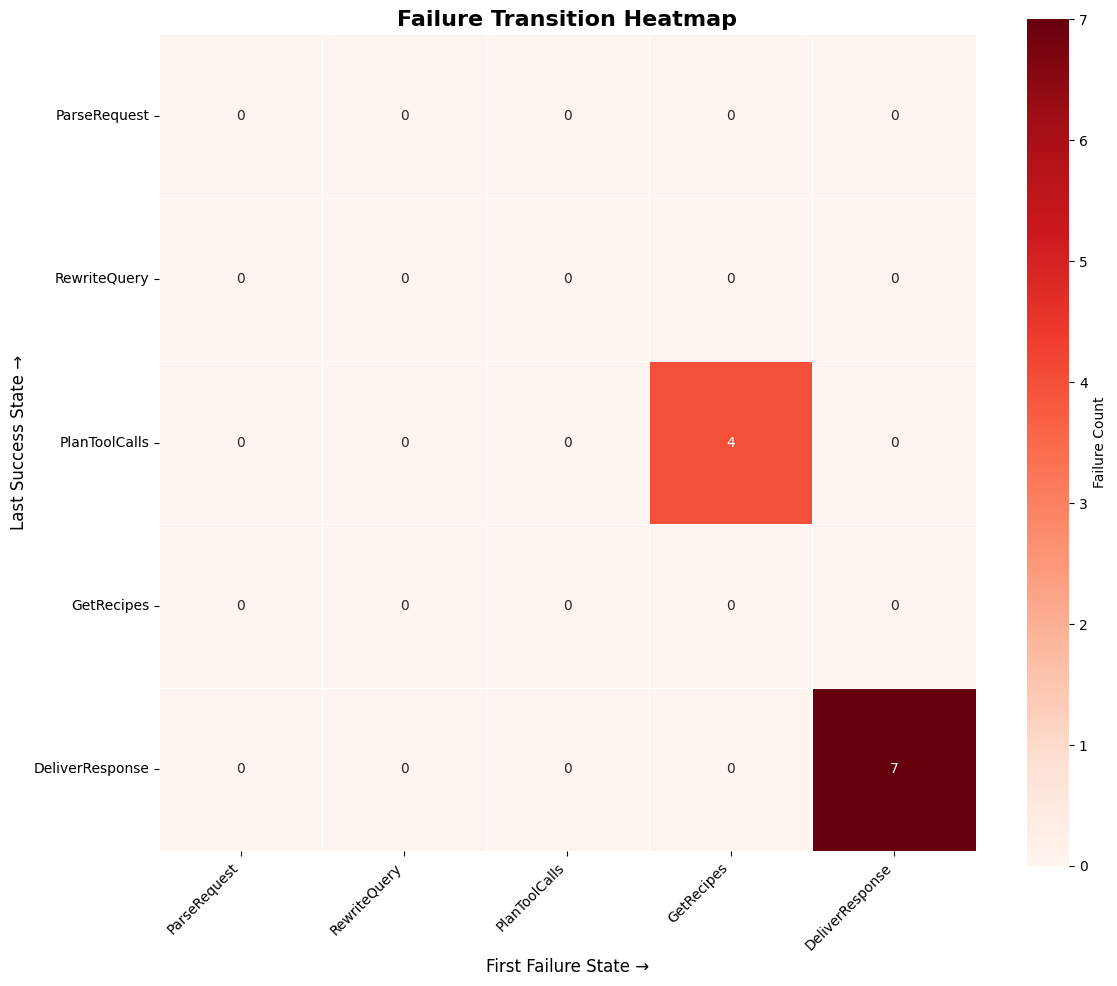


Transition matrix shape: (5, 5)
Total failure transitions: 11.0
Non-zero transitions: 2


In [109]:
# Create failure transition heatmap using actual agent steps from the data
def create_failure_transition_heatmap(logs_data):
    # Extract all unique agent steps from the data
    all_steps = set()
    transitions = []

    for log in logs_data:
        last_success = log.get("last_success_step")
        first_failure = log.get("first_failure_step")

        if last_success:
            all_steps.add(last_success)
        if first_failure and first_failure != "none":
            all_steps.add(first_failure)

        # Extract transition if both exist and failure is not "none"
        if last_success and first_failure and first_failure != "none":
            transitions.append((last_success, first_failure))

    print(f"Found {len(transitions)} failure transitions")
    print(f"All agent steps in data: {sorted(all_steps)}")

    # Use the actual agent steps from the image in the correct order
    # Based on the image provided, these are the steps shown
    agent_steps = [
        "ParseRequest",
        "RewriteQuery",
        "PlanToolCalls",
        "GetRecipes",
        "DeliverResponse",
    ]

    # Create mapping from actual data steps to display steps
    step_mapping = {
        "start": "ParseRequest",
        "query_rewrite": "RewriteQuery",
        "tool_calls": "PlanToolCalls",
        "find_matching_recipes": "GetRecipes",
        "stop": "DeliverResponse",
        "none": "ParseRequest",
    }

    # Create transition matrix
    transition_matrix = np.zeros((len(agent_steps), len(agent_steps)))
    step_to_idx = {step: i for i, step in enumerate(agent_steps)}

    for last_success, first_failure in transitions:
        # Map the actual step names to display names
        mapped_last = step_mapping.get(last_success, last_success)
        mapped_first = step_mapping.get(first_failure, first_failure)

        # Find indices in our agent_steps list
        last_idx = None
        first_idx = None

        if mapped_last in step_to_idx:
            last_idx = step_to_idx[mapped_last]
        if mapped_first in step_to_idx:
            first_idx = step_to_idx[mapped_first]

        # If we couldn't map directly, try partial matching
        if last_idx is None:
            for i, step in enumerate(agent_steps):
                if last_success.lower() in step.lower() or step.lower() in last_success.lower():
                    last_idx = i
                    break

        if first_idx is None:
            for i, step in enumerate(agent_steps):
                if first_failure.lower() in step.lower() or step.lower() in first_failure.lower():
                    first_idx = i
                    break

        if last_idx is not None and first_idx is not None:
            transition_matrix[last_idx][first_idx] += 1
            print(f"Mapped: {last_success} -> {first_failure} as {agent_steps[last_idx]} -> {agent_steps[first_idx]}")

    # Create the heatmap
    plt.figure(figsize=(12, 10))

    # Create heatmap matching the style in the image
    sns.heatmap(
        transition_matrix,
        xticklabels=agent_steps,
        yticklabels=agent_steps,
        annot=True,
        fmt="g",
        cmap="Reds",
        cbar_kws={"label": "Failure Count"},
        square=True,
        linewidths=0.5,
    )

    plt.title("Failure Transition Heatmap", fontsize=16, fontweight="bold")
    plt.xlabel("First Failure State →", fontsize=12)
    plt.ylabel("Last Success State →", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    return plt.gcf(), transition_matrix, transitions


# Create the heatmap using all logs
fig, matrix, transitions = create_failure_transition_heatmap(logs)
plt.show()

print(f"\nTransition matrix shape: {matrix.shape}")
print(f"Total failure transitions: {matrix.sum()}")
print(f"Non-zero transitions: {np.count_nonzero(matrix)}")

See the "failure_transation_analysis_summary.md" file to a summarization of my findings above.
